In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error, plot_roc_curve, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:

def my_cross_validation(estimator, X, y, k):
    kf = KFold(n_splits=k, shuffle = True, random_state=0)
    rocaucs = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        estimator.fit(X_train, y_train)
        y_pred = estimator.predict_proba(X_test)[:,1]
        rocauc = roc_auc_score(y_test, y_pred)
        rocaucs.append(rocauc)
        print(rocauc)
    return np.mean(rocaucs), np.std(rocaucs)

def normalize(features):
    for f in features:
        if abs(train[f].max()) > abs(train[f].min()):
            train[f] = (train[f] - train[f].mean()) / train[f].max()
            test[f] = (test[f] - test[f].mean()) / test[f].max()
        else:
            train[f] = (train[f] - train[f].mean()) / train[f].min()
            test[f] = (test[f] - test[f].mean()) / test[f].min()


In [3]:
train = pd.read_csv('application_train.csv')
test  = pd.read_csv('application_test.csv')
submission = pd.read_csv('sample_submission.csv')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
features = ["DAYS_BIRTH",
            "REGION_RATING_CLIENT_W_CITY",
            "DAYS_LAST_PHONE_CHANGE",
            "EXT_SOURCE_1",
            "EXT_SOURCE_2",
            "EXT_SOURCE_3"]
for f in features:
    train[f] = train[f].fillna(train[f].median())
    test[f] = test[f].fillna(test[f].median())
normalize(features)

replace_dict = {
    "CODE_GENDER": {"M": 0, "F": 1, "XNA": np.nan},
    "NAME_CONTRACT_TYPE": {"Cash loans": 0, "Revolving loans": 1},
    "EMERGENCYSTATE_MODE": {"No": 0, "Yes": 0}
}

for k in replace_dict.keys():
    train[k] = train[k].replace(replace_dict[k])
    test[k] = test[k].replace(replace_dict[k])

for k in replace_dict.keys():
    train[k] = train[k].fillna(train[k].median())
    test[k] = test[k].fillna(test[k].median())

features += replace_dict.keys()

# Task 0

params
* n_estimators
* max_depth
* min_samples_leaf
* loss

In [5]:
n_estimators = [1, 2, 3, 5, 10, 20, 50, 100]
n_estimators_res = []
for n in n_estimators:
    print(n)
    gbc = GradientBoostingClassifier(random_state=0, n_estimators=n)
    res = my_cross_validation(gbc, train[features], train["TARGET"], 3)
    n_estimators_res.append(res[0])

1
0.6843626112909345
0.6811711679833282
0.6874816614328961
2
0.6894633915069381
0.690691017073026
0.6958887625076873
3
0.7008789806923615
0.6960769886558424
0.6964291637919914
5
0.7074591940060523
0.6993731572801651
0.7005794158981591
10
0.714205554002634
0.7102390165650918
0.7135012415749361
20
0.7240135417144934
0.7202347741752416
0.7250460781382697
50
0.7312148547091357
0.7293298640803928
0.7337098511449793
100
0.7341691819326848


KeyboardInterrupt: 

In [62]:
n_estimators_res

[0.6843384802357195,
 0.6918747108780594,
 0.6976692560514431,
 0.7019875357383786,
 0.7121822770793559,
 0.7216826677147529,
 0.7298147184916036,
 0.733161624663289]

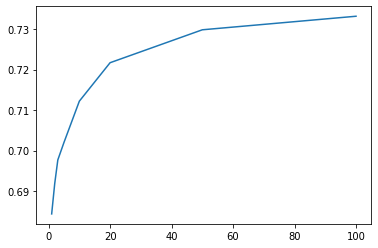

In [63]:
plt.plot(n_estimators, n_estimators_res)

In [64]:
max_depthes = [1, 2, 3, 4, 5, 10, 15, 20]
max_depthes_res = []
for d in max_depthes:
    print(d)
    gbc = GradientBoostingClassifier(random_state=0, n_estimators=10, max_depth=d)
    res = my_cross_validation(gbc, train[features], train["TARGET"], 5)
    max_depthes_res.append(res[0])

1
0.6934406247495692
0.6951593556061912
0.6858552557117273
0.6879401053237924
0.6914729651290694
2
0.7020969214406025
0.7049907529511236
0.6953277490599865
0.7010172736666799
0.6999537587025021
3
0.712354171990405
0.7158195967103809
0.708712043719189
0.7107866763891681
0.7143725574892569
4
0.7188003852289768
0.7212511409792427
0.7155754914401145
0.7182649423451447
0.7195992202298556
5
0.7224079345359442
0.7244357207399584
0.7192575195743909
0.723212450952377
0.7243400990316826
10
0.7248840091650958
0.7269254576300943
0.7239749115224852
0.7276632818778039
0.7281750365671498
15
0.6998381844133741
0.706121334840693
0.7040732454587426
0.7043483216346755
0.7020249094494141
20
0.6561825709303745
0.6647970640296259
0.660187115048602
0.6626200359313071
0.6555300128443349


In [65]:
max_depthes_res

[0.6907736613040699,
 0.7006772911641789,
 0.71240900925968,
 0.7186982360446669,
 0.7227307449668706,
 0.7263245393525258,
 0.7032811991593799,
 0.6598633597568488]

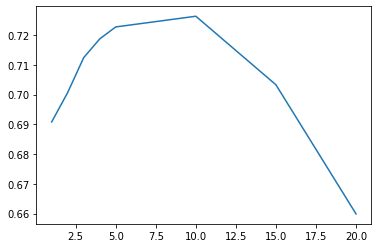

In [66]:
plt.plot(max_depthes, max_depthes_res)

In [67]:
min_samples_leafs = [1, 10, 100, 1000, 10000, 20000]
min_samples_leafs_res = []
for l in min_samples_leafs:
    print(l)
    gbc = GradientBoostingClassifier(random_state=0, n_estimators=10, min_samples_leaf=l)
    res = my_cross_validation(gbc, train[features], train["TARGET"], 5)
    min_samples_leafs_res.append(res[0])

1
0.712354171990405
0.7158195967103809
0.708712043719189
0.7107866763891681
0.7143725574892569
10
0.712354171990405
0.7158195967103809
0.708712043719189
0.7107866763891681
0.7143725574892569
100
0.7123431875759838
0.7159002066002805
0.708712043719189
0.7107866763891681
0.7143725574892569
1000
0.712383051074
0.7160425153229895
0.7087157488196709
0.7113679875213844
0.7143713182535089
10000
0.7118304361288844
0.7140789592450636
0.7076452879877441
0.7110060757131031
0.7124431714337933
100000
0.6388686885794523
0.6464105792813633
0.6422804729744063
0.6428034508042295
0.6385954015504585


In [68]:
min_samples_leafs_res

[0.71240900925968,
 0.71240900925968,
 0.7124229343547757,
 0.7125761241983107,
 0.7114007861017178,
 0.6417917186379819]

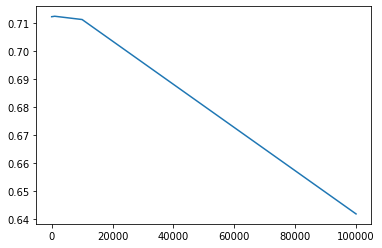

In [69]:
plt.plot(min_samples_leafs, min_samples_leafs_res)

In [70]:
losses = ["squared_error", "absolute_error", "huber", "quantile"]
losses_res = []
for l in losses:
    print(l)
    gbc = GradientBoostingClassifier(random_state=0, n_estimators=10, loss=l)
    res = my_cross_validation(gbc, train[features], train["TARGET"], 5)
    losses_res.append(res[0])

squared_error
0.712354171990405
0.7158195967103809
0.708712043719189
0.7107866763891681
0.7143725574892569
absolute_error
0.5
0.5
0.5
0.5
0.5
huber
0.5
0.5
0.5
0.5
0.5
quantile
0.6462106042758714
0.6406458563443456
0.6345783965805731
0.6390012838328977
0.6432815547850081


In [71]:
losses_res

[0.71240900925968, 0.5, 0.5, 0.6407435391637392]

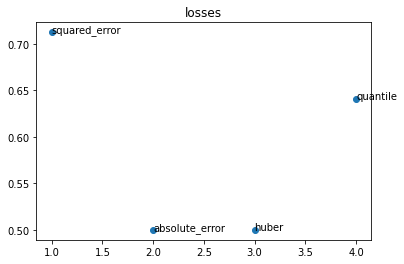

In [72]:
fig, ax = plt.subplots()
ax.scatter([1, 2, 3, 4], losses_res)
plt.title("losses")
for i, txt in enumerate(losses):
    ax.annotate(txt, ([1, 2, 3, 4][i], losses_res[i]))

Параметр n_estimators не влияет на переобучение, так как на большем количестве моделей результат просто перестает меняться, оставаясь максимально возможным в данной конфигурации

Из-за параметра max_depth начинается переобучение на значении 10-15, так как модель становится слишком сложной

Параметр min_samples_leaf на больших значениях наоборот оставляет модель недообученной

Параметр loss не связан с переобучением, просто для данной задачи лучше всего подходит squared_error


# Task 1

In [14]:
# уменьшил списки для быстроты
params = {
    "n_estimators": [100],
    "max_depth": [8, 10, 12],
    "min_samples_leaf": [1]
    #"loss": ["squared_error", "absolute_error", "huber", "quantile"]
}

gbc = GradientBoostingClassifier()
gscv = GridSearchCV(gbc, params, verbose=True)
gscv.fit(train[features], train["TARGET"])

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [8], 'min_samples_leaf': [1, 100, 10000],
                         'n_estimators': [10]})

In [15]:
gscv.best_params_

{'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 10}

In [38]:
features

['DAYS_BIRTH',
 'REGION_RATING_CLIENT_W_CITY',
 'DAYS_LAST_PHONE_CHANGE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'CODE_GENDER',
 'NAME_CONTRACT_TYPE',
 'EMERGENCYSTATE_MODE']

In [39]:
gscv.best_estimator_.feature_importances_

array([0.0738615 , 0.00875884, 0.03114703, 0.12177108, 0.35653907,
       0.36973   , 0.02792801, 0.01026447, 0.        ])

In [ ]:
my_cross_validation(gscv.best_estimator_, train[features], train["TARGET"], 5)

In [34]:
rscv = RandomizedSearchCV(gbc, params)
rscv.fit(train[features], train["TARGET"])

C:\Users\Valeriy\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(estimator=GradientBoostingClassifier(),
                   param_distributions={'max_depth': [8],
                                        'min_samples_leaf': [1, 100, 10000],
                                        'n_estimators': [10]})

In [35]:
rscv.best_params_

{'n_estimators': 10, 'min_samples_leaf': 1, 'max_depth': 8}

In [36]:
rscv.best_estimator_.feature_importances_

array([0.0753405 , 0.00876786, 0.03266402, 0.12063792, 0.35642383,
       0.36800477, 0.02784039, 0.01032072, 0.        ])

# Task 2

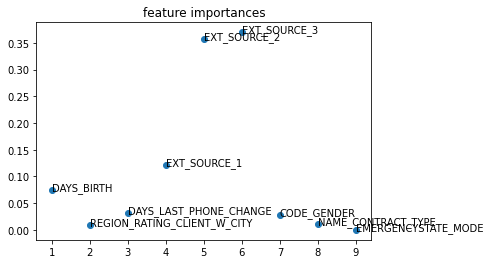

In [23]:
fig, ax = plt.subplots()
ax.scatter(range(1, len(features)+1), gscv.best_estimator_.feature_importances_)
plt.title("feature importances")
for i, txt in enumerate(features):
    ax.annotate(txt, (i + 1, gscv.best_estimator_.feature_importances_[i]))

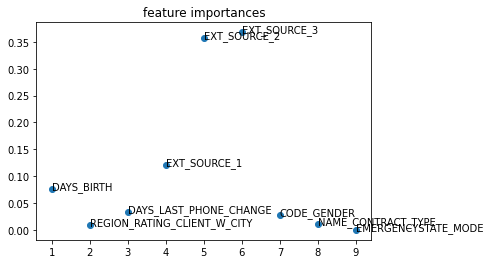

In [37]:
fig, ax = plt.subplots()
ax.scatter(range(1, len(features)+1), rscv.best_estimator_.feature_importances_)
plt.title("feature importances")
for i, txt in enumerate(features):
    ax.annotate(txt, (i + 1, rscv.best_estimator_.feature_importances_[i]))

EXT_SOURCE_3 и EXT_SOURCE_2 самые важные

# Stacking
# Task 1

In [40]:
gbc1 = GradientBoostingClassifier(n_estimators=10, max_depth=5)
gbc2 = GradientBoostingClassifier(n_estimators=2, max_depth=2)
rfc1 = RandomForestClassifier(n_estimators=2)
rfc2 = RandomForestClassifier(n_estimators=5, min_samples_leaf=1000)
lr = LogisticRegression()

estimators = [("gbc1", gbc1), ("gbc2", gbc2), ("rfc1", rfc1), ("rfc2", rfc2), ("lr", lr)]
sc = StackingClassifier(estimators=estimators)
my_cross_validation(sc, train[features], train["TARGET"], 4)


0.7278210141743012
0.7313680972635122
0.7263563843768932
0.728894204518151


(0.7286099250832145, 0.001829559695018529)

In [41]:
sc.fit(train[features], train["TARGET"])
y_pred = sc.predict_proba(test[features])[:,1]
submission['TARGET'] = y_pred
submission.to_csv('predict1.csv', index = False)

cv roc-auc mean/std 0.7286099250832145, 0.001829559695018529

lb private/public 0.71068 0.72221

# Task 2

In [42]:
gbc12 = GradientBoostingClassifier(n_estimators=10, max_depth=5)
gbc22 = GradientBoostingClassifier(n_estimators=2, max_depth=2)
rfc12 = RandomForestClassifier(n_estimators=2)
rfc22 = RandomForestClassifier(n_estimators=5, min_samples_leaf=1000)
lr2 = LogisticRegression()

estimators2 = [("gbc22", gbc22), ("rfc12", rfc12), ("rfc22", rfc22), ("lr2", lr2)]
sc2 = StackingClassifier(estimators=estimators2)
my_cross_validation(sc2, train[features], train["TARGET"], 4)

0.7274230353253577
0.7290525646008336
0.7273276386534016
0.7297420963956581


(0.7283863337438127, 0.0010405209104631557)

In [43]:
sc2.fit(train[features], train["TARGET"])
y_pred = sc2.predict_proba(test[features])[:,1]
submission['TARGET'] = y_pred
submission.to_csv('predict2.csv', index = False)

cv roc-auc mean/std 0.7283863337438127, 0.0010405209104631557

lb private/public 0.71009 0.71911

Результат немного ухудшился, но не сильно, так как модели отличаются тоже не сильно
